In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import glob

sentences = []
with open('words.txt','r') as f:
    while True:
        line = f.readline().strip().replace('\'','').replace('\"','') 
        if line == '':
            break
        if line[0]!='#':
            sentences.append(line.split(' '))


In [3]:
import csv
df = pd.DataFrame(sentences)
df = pd.DataFrame(df.iloc[:,[0,8]])
df.columns = ['id','text']
df.head()

,id,text
0,a01-000u-00-00,A
1,a01-000u-00-01,MOVE
2,a01-000u-00-02,to
3,a01-000u-00-03,stop
4,a01-000u-00-04,Mr.


(51, 27)


0    A
Name: text, dtype: object

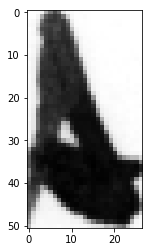

In [5]:
import cv2

img_path = 'words/a01/a01-000u/*'

img = cv2.imread(glob.glob(img_path)[0], cv2.IMREAD_GRAYSCALE)
print(img.shape)

plt.imshow(img, cmap='Greys_r')
df['text'].head(1)

In [8]:
import os
directory = 'words'

X_train,X_labels = [],[]
for c,img in enumerate(os.walk(directory)):
    if c<2:
        continue
    for each in img[2]:
        path = img[0]+'/'+each
        X_labels.append(path)
        X_train.append(cv2.imread(path, cv2.IMREAD_GRAYSCALE))

identifier = X_labels[-2].split('/')[-1][:-4]
df[df['id']==identifier]['text']


115318    garden
Name: text, dtype: object

In [15]:
identifiers = []
for each in X_labels:
    identifiers.append(each.split('/')[-1][:-4])

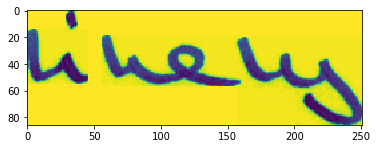

In [23]:
plt.imshow(X_train[200])

In [24]:
print(identifiers[200],df[df['id']==identifiers[200]]['text'],df['text'][200])

a01-003u-02-02 200    likely
Name: text, dtype: object likely


In [40]:
vocab = np.array(df['text'])
print(vocab)

['A' 'MOVE' 'to' ... 'the' 'garden' '?']


In [41]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=115300) # max num of words
tokenizer.fit_on_texts(vocab)

In [45]:
df['text_to_int'] = [tokenizer.texts_to_sequences(each) for each in df['text']]

In [46]:
df['text_to_int'].head()

0                              [[5]]
1    [[135], [1306], [2322], [1525]]
2                   [[1701], [1306]]
3      [[65], [1701], [1306], [709]]
4                 [[135], [412], []]
Name: text_to_int, dtype: object

In [47]:
y_train = np.array(df['text_to_int'])
y_train.shape

(115320,)

In [25]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Lambda, Dropout
from keras.optimizers import Adam

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
print(len(df),len(X_labels),len(X_train))

115320 115320 115320


In [27]:
X_train[0].shape

(51, 27)

In [65]:
images = []
for img in X_train:
    try:
        images.append(cv2.resize(img,(56,56,1)))
    except Exception as e:
        images.append(np.zeros((56,56,1)))

print(images[0].shape)

(56, 56, 1)


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(images, y_train, test_size=0.2, random_state=0)

In [68]:
images_test = []
for img in X_test:
    try:
        images_test.append(cv2.resize(img,(56,56,1)))
    except Exception as e:
        images_test.append(np.zeros((56,56,1)))

print(images_test[0].shape)
images_test = np.array(images_test)
images_test.shape

(56, 56, 1)


(23064, 56, 56, 1)

In [67]:
images = np.array(images)
images.shape

(92256, 56, 56, 1)

In [73]:
model = Sequential()

model.add(Conv2D(32,kernel_size=(5,5),strides=(2,2),activation='relu',input_shape=(56,56,1)))
model.add(MaxPooling2D())
model.add(Conv2D(64,kernel_size=(5,5),strides=(2,2),activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(26,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 26, 26, 32)        832       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 5, 5, 64)          51264     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 256)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 26)                6682      
__________

In [74]:
model.fit(images, y_train, epochs=3, validation_data=(images_test,y_test), batch_size=32)

Instructions for updating:
Use tf.cast instead.
Train on 92256 samples, validate on 23064 samples
Epoch 1/3


ValueError: setting an array element with a sequence.

In [ ]:
model.save('handwritten_text.h5')

In [ ]:
from keras.models import load_model

hw_model = load_model('handwritten_text.h5')